# Funzioni

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(confusion_matrix=cmn).plot()
  return y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

In [ ]:
def xtab(dataset, index_col, columns_col, normalize_on_idx=False):
  xtab = pd.crosstab(dataset[index_col], dataset[columns_col])
  if normalize_on_idx:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / len(dataset[dataset[index_col] == i])
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Parte 1: Analisi

1

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/weather_train.csv')
dataset.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2016-05-26 09:00:00+02:00,Bilbao,288.420,285.150,290.930,1012,93,0,0,0.0,0.0,0.0,75,803,clouds,broken clouds,04d
1,2016-07-16 10:00:00+02:00,Madrid,299.037,299.037,299.037,961,44,2,83,0.0,0.0,0.0,0,800,clear,sky is clear,01d
2,2018-06-03 05:00:00+02:00,Madrid,285.150,285.150,285.150,1017,100,0,0,0.0,0.0,0.0,56,803,clouds,broken clouds,04n
3,2018-10-19 10:00:00+02:00,Valencia,289.150,289.150,289.150,1011,100,4,320,0.9,0.0,0.0,75,521,rain,shower rain,09d
4,2017-11-25 07:00:00+01:00,Seville,279.940,279.150,281.150,1019,81,0,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
dataset.info() # dataset completo, non ci sono missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158131 entries, 0 to 158130
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               158131 non-null  object 
 1   city_name            158131 non-null  object 
 2   temp                 158131 non-null  float64
 3   temp_min             158131 non-null  float64
 4   temp_max             158131 non-null  float64
 5   pressure             158131 non-null  int64  
 6   humidity             158131 non-null  int64  
 7   wind_speed           158131 non-null  int64  
 8   wind_deg             158131 non-null  int64  
 9   rain_1h              158131 non-null  float64
 10  rain_3h              158131 non-null  float64
 11  snow_3h              158131 non-null  float64
 12  clouds_all           158131 non-null  int64  
 13  weather_id           158131 non-null  int64  
 14  weather_main         158131 non-null  object 
 15  weather_descripti

In [ ]:
dataset.weather_main.value_counts()

clear     77750
clouds    64130
rain      16251
Name: weather_main, dtype: int64

In [ ]:
"""
dataset non bilanciato rispetto alla classe da predirre: 'rain' ha molte meno
occorrenze di 'clear' e 'cloud'
"""

"\ndataset non bilanciato rispetto alla classe da predirre: 'rain' ha molte meno\noccorrenze di 'clear' e 'cloud'\n"

2

In [ ]:
print("N. of instances where Pressure is 0:", (dataset.pressure == 0).sum())
print("N. of instances where Humidity is 0:", (dataset.humidity == 0).sum())
print("N. of instances where both Pressure and Humidity are 0:",
      ((dataset.humidity == 0) & (dataset.pressure == 0)).sum())

N. of instances where Pressure is 0: 2
N. of instances where Humidity is 0: 59
N. of instances where both Pressure and Humidity are 0: 0


In [ ]:
dataset.drop(index=dataset[dataset.pressure == 0].index, inplace=True)
dataset.drop(index=dataset[dataset.humidity == 0].index, inplace=True)

3

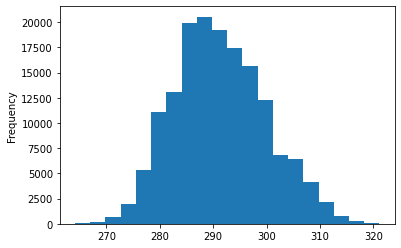

In [ ]:
dataset.temp_max.plot(kind='hist', bins=20)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


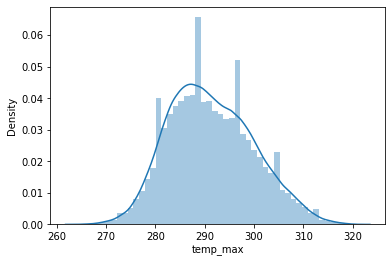

In [ ]:
sns.distplot(dataset.temp_max)

In [ ]:
index = (dataset.temp_max >= dataset.temp_max.quantile(0.95))
dataset_top_5pc = dataset[index]
dataset_top_5pc.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
28,2016-07-21 20:00:00+02:00,Madrid,308.150,308.150,308.150,1013,12,3,210,0.0,0.0,0.0,0,800,clear,sky is clear,01d
34,2016-05-29 14:00:00+02:00,Seville,301.050,294.150,312.150,1020,43,3,260,0.0,0.0,0.0,20,801,clouds,few clouds,02d
39,2015-05-12 17:00:00+02:00,Madrid,306.249,306.249,306.249,961,26,2,221,0.0,0.0,0.0,0,800,clear,sky is clear,01d
50,2016-06-24 18:00:00+02:00,Barcelona,300.290,296.480,307.040,1017,69,6,210,3.0,0.0,0.0,0,502,rain,heavy intensity rain,10d
65,2016-09-12 19:00:00+02:00,Seville,305.960,304.150,307.150,1011,48,6,250,0.0,0.0,0.0,0,800,clear,sky is clear,01d


In [ ]:
dataset_top_5pc.city_name.value_counts()

Seville       5297
Madrid        2181
 Barcelona     629
Valencia       614
Bilbao         391
Name: city_name, dtype: int64

weather_main     clear    clouds      rain
city_name                                 
 Barcelona    0.476948  0.480127  0.042925
Bilbao        0.542199  0.447570  0.010230
Madrid        0.784503  0.205869  0.009629
Seville       0.843308  0.128375  0.028318
Valencia      0.488599  0.508143  0.003257


weather_main,clear,clouds,rain
city_name,,,
Barcelona,0.476948,0.480127,0.042925
Bilbao,0.542199,0.447570,0.010230
Madrid,0.784503,0.205869,0.009629
Seville,0.843308,0.128375,0.028318
Valencia,0.488599,0.508143,0.003257


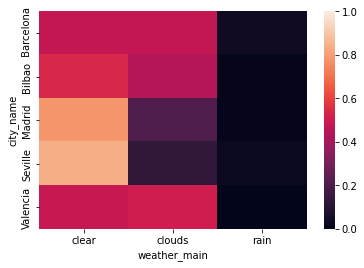

In [ ]:
xtab(dataset_top_5pc, 'city_name', 'weather_main', normalize_on_idx=True)

4

In [ ]:
dataset.snow_3h.describe()

count    158070.000000
mean          0.004828
std           0.229147
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.500000
Name: snow_3h, dtype: float64

In [ ]:
snow = dataset[dataset.snow_3h > 0]
snow.temp.mean()

276.11875101273137

5

In [ ]:
(snow.temp_max - snow.temp_min).mean()

0.0

In [ ]:
(dataset_top_5pc.temp_max - dataset_top_5pc.temp_min).mean()

7.372107111501318

# Parte 2: Trasformazione e Predizione

1

In [ ]:
dataset1 = dataset.drop(columns=["dt_iso","city_name","weather_description",
                                 "weather_icon","weather_id", "clouds_all"])

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder().fit(dataset1.weather_main)
dataset1.weather_main = enc.transform(dataset1.weather_main)

In [ ]:
dataset1.weather_main.value_counts()

0    77719
1    64112
2    16239
Name: weather_main, dtype: int64

In [ ]:
train, test = train_test_split(dataset1, train_size=2/3, random_state=1)

In [ ]:
X_tr = train.drop(columns='weather_main')
y_tr = train.weather_main
X_ts = test.drop(columns='weather_main')
y_ts = test.weather_main

Accuracy: 0.9968210286581894
Confusion matrix:
 [[51937    34     0]
 [  301 42280     0]
 [    0     0 10828]]


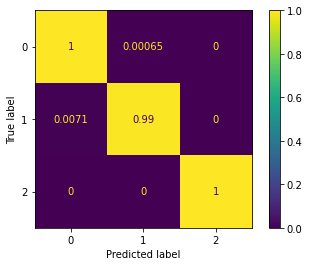

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.6964509394572025
Confusion matrix:
 [[17743  8005     0]
 [ 7988 13543     0]
 [    0     1  5410]]


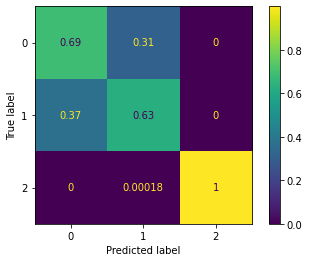

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.5735243879293984
Confusion matrix:
 [[37383 14258   330]
 [19948 22158   475]
 [ 2215  7716   897]]


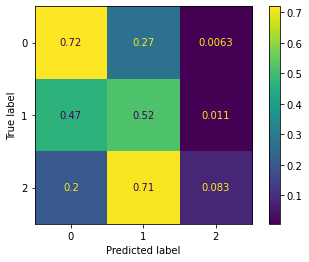

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, LogisticRegression(n_jobs=-1))

Accuracy: 0.5707914215221105
Confusion matrix:
 [[18503  7073   172]
 [10149 11142   240]
 [ 1134  3847   430]]


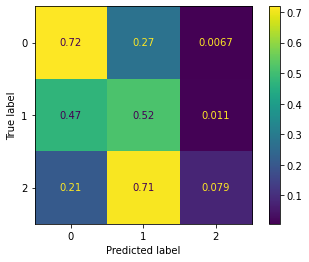

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, LogisticRegression(n_jobs=-1))

2

In [ ]:
X = pd.concat([X_tr, X_ts])
y = pd.concat([y_tr, y_ts])

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y,
                scoring='accuracy', cv=10, n_jobs=-1).mean()

0.7096792560258113

In [ ]:
cross_val_score(LogisticRegression(), X, y,
                scoring='accuracy', cv=10, n_jobs=-1).mean()

0.5676092870247358

3

In [ ]:
from sklearn.preprocessing import Normalizer

nrm = Normalizer().fit(X)
X_nrm = pd.DataFrame(nrm.transform(X), columns=X.columns)
X_nrm.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h
0,0.259567,0.255434,0.265854,0.883141,0.063392,0.000000,0.112889,0.0,0.000000,0.0
1,0.249699,0.249699,0.249699,0.892858,0.051545,0.000874,0.114447,0.0,0.000041,0.0
2,0.247546,0.247036,0.247915,0.899752,0.081716,0.000879,0.000000,0.0,0.000000,0.0
3,0.258376,0.256822,0.259442,0.894054,0.025320,0.000873,0.000000,0.0,0.000000,0.0
4,0.254603,0.254186,0.255159,0.867006,0.062550,0.000869,0.223267,0.0,0.000069,0.0


In [ ]:
cross_val_score(DecisionTreeClassifier(), X_nrm, y,
                scoring='accuracy', cv=10, n_jobs=-1).mean()

0.6935534889605871

4

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=5)

def return_this(arg):
  return arg

pca_combiner = FeatureUnion([('pca', pca),
                             ('passthrough', FunctionTransformer(return_this,
                                                                 validate=False))])
pipeline = Pipeline([('pca_combiner', pca_combiner),
                     ('normalizer', Normalizer()),
                     ('classifier', DecisionTreeClassifier())], verbose=True)

[Pipeline] ...... (step 1 of 3) Processing pca_combiner, total=   0.4s
[Pipeline] ........ (step 2 of 3) Processing normalizer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   3.3s
Accuracy: 0.694591003985576
Confusion matrix:
 [[17848  7900     0]
 [ 8191 13339     1]
 [    0     0  5411]]


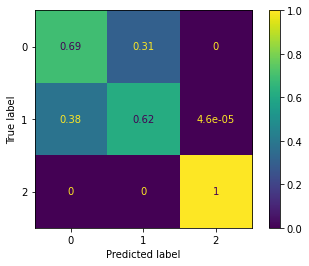

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, pipeline)

5

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca_combiner__pca__n_components': ['mle', 4, 5, 6],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': [2, 3, 4, 5]
}

In [ ]:
gs = GridSearchCV(pipeline, param_grid, scoring='accuracy',
                  n_jobs=-1, cv=10, verbose=3).fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[Pipeline] ...... (step 1 of 3) Processing pca_combiner, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing normalizer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   2.4s


In [ ]:
gs.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_features': 'auto',
 'classifier__min_samples_split': 3,
 'pca_combiner__pca__n_components': 'mle'}

In [ ]:
gs.best_score_ # inferiore all'accuratezza ottenuta in precedenza

0.7104320870500411

6

In [ ]:
weather_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/weather_test.csv')
weather_test.head()

,Unnamed: 0,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_description,weather_icon
0,0,2015-10-23 18:00:00+02:00,Madrid,293.150,293.150,293.150,1019,45,2,200,0.0,0.0,0.0,0,800,sky is clear,01d
1,1,2015-01-01 06:00:00+01:00,Madrid,265.442,265.442,265.442,972,64,0,240,0.0,0.0,0.0,0,800,sky is clear,01n
2,2,2015-07-24 22:00:00+02:00,Madrid,302.870,301.050,304.150,1012,29,6,290,0.0,0.0,0.0,0,800,sky is clear,01n
3,3,2015-05-27 22:00:00+02:00,Madrid,291.944,291.944,291.944,956,34,3,29,0.0,0.0,0.0,0,800,sky is clear,01n
4,4,2015-07-06 18:00:00+02:00,Madrid,312.540,310.650,313.150,1017,11,5,220,0.0,0.0,0.0,20,801,few clouds,02d


In [ ]:
weather_class = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/weather_class.csv')
weather_class.head()

,Unnamed: 0,weather_main
0,0,clear
1,1,clear
2,2,clear
3,3,clear
4,4,clouds


In [ ]:
X_test = weather_test[X.columns]
X_test

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h
0,293.150,293.150,293.150,1019,45,2,200,0.0,0.0,0.0
1,265.442,265.442,265.442,972,64,0,240,0.0,0.0,0.0
2,302.870,301.050,304.150,1012,29,6,290,0.0,0.0,0.0
3,291.944,291.944,291.944,956,34,3,29,0.0,0.0,0.0
4,312.540,310.650,313.150,1017,11,5,220,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,290.060,282.150,300.150,1024,81,4,70,0.0,0.0,0.0
9996,276.540,276.150,277.150,1025,86,0,0,0.0,0.0,0.0
9997,289.190,287.590,291.150,1020,63,3,70,0.0,0.0,0.0
9998,292.110,290.150,295.150,1018,64,1,348,0.0,0.0,0.0


In [ ]:
y_test = pd.Series(enc.transform(weather_class['weather_main']))
y_test.head()

0    0
1    0
2    0
3    0
4    1
dtype: int64

In [ ]:
X = dataset1.drop(columns='weather_main')
X.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h
0,288.420,285.150,290.930,1012,93,0,0,0.0,0.0,0.0
1,299.037,299.037,299.037,961,44,2,83,0.0,0.0,0.0
2,285.150,285.150,285.150,1017,100,0,0,0.0,0.0,0.0
3,289.150,289.150,289.150,1011,100,4,320,0.9,0.0,0.0
4,279.940,279.150,281.150,1019,81,0,50,0.0,0.0,0.0


In [ ]:
y = dataset1.weather_main
y.head()

0    1
1    0
2    1
3    2
4    0
Name: weather_main, dtype: int64

[Pipeline] ...... (step 1 of 3) Processing pca_combiner, total=   0.5s
[Pipeline] ........ (step 2 of 3) Processing normalizer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   5.2s
Accuracy: 0.7059
Confusion matrix:
 [[3464 1471    0]
 [1470 2455    0]
 [   0    0 1140]]


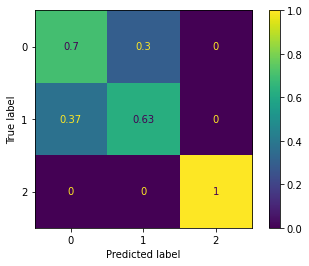

In [ ]:
_ = fit_predict_print_1(X, X_test, y, y_test, pipeline)

7

In [ ]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([('pca_combiner', pca_combiner),
                     ('normalizer', Normalizer()),
                     ('classifier', LinearRegression(n_jobs=-1))], verbose=True)

In [ ]:
train, test = train_test_split(dataset1, train_size=2/3, random_state=1)

In [ ]:
X_tr = train.drop(columns='weather_main')
y_tr = train.weather_main
X_ts = test.drop(columns='weather_main')
y_ts = test.weather_main

In [ ]:
pred = pipeline.fit(X_tr, y_tr).predict(X_ts)
y_pr = np.round(np.clip(pred, 0, 2))

[Pipeline] ...... (step 1 of 3) Processing pca_combiner, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing normalizer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


In [ ]:
metrics.accuracy_score(y_ts, y_pr)

0.5708673372556462

[[13296 12441    11]
 [ 5408 16118     5]
 [   51  4695   665]]


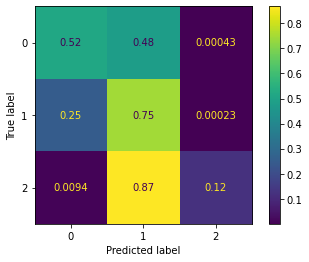

In [ ]:
print(metrics.confusion_matrix(y_ts, y_pr))
cmn = metrics.confusion_matrix(y_ts, y_pr, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cmn).plot()

In [ ]:
pred = pipeline.fit(X_tr, y_tr).predict(X_tr)
y_pr = np.round(np.clip(pred, 0, 2))

[Pipeline] ...... (step 1 of 3) Processing pca_combiner, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing normalizer, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


In [ ]:
metrics.accuracy_score(y_tr, y_pr)

0.5680584551148226

[[26701 25252    18]
 [10793 31779     9]
 [  105  9341  1382]]


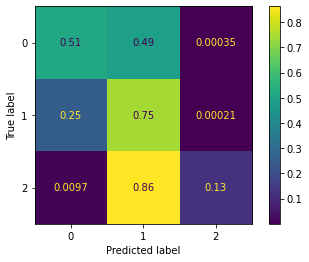

In [ ]:
print(metrics.confusion_matrix(y_tr, y_pr))
cmn = metrics.confusion_matrix(y_tr, y_pr, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cmn).plot()